In [1]:
import xarray as xr
import numpy as np
import dask
from tqdm import tqdm


import regionate
import matplotlib.pyplot as plt

import xwmb
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')
import xbudget

import cftime
import cmocean

In [2]:
xwmb.__version__, xwmt.__version__, xgcm.__version__

('0.1.0', '0.1.1', '0.8.2.dev15+g7492277')

In [3]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/data_daily/"
ds = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily.*.nc", chunks={"time":1})
snap = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily_snap*.nc", chunks={"time":1})
static = xr.open_dataset("/pub/hfdrake/datasets/CM4_MHW_blobs/data/WMT_monthly/ocean_month_rho2.static.nc")#chunks={'time':1})

In [4]:
# Merge snapshots with time-averages
snap = snap.rename({
    **{'time':'time_bounds'},
    **{v:f"{v}_bounds" for v in snap.data_vars}
})
ds = xr.merge([ds.sel(time=ds.time[1:]), snap])
ds

<xarray.Dataset>
Dimensions:                         (time: 1459, xh: 269, yh: 130, zl: 75,
                                     xq: 270, yq: 131, time_bounds: 1460)
Coordinates:
  * time                            (time) object 0186-01-02 12:00:00 ... 018...
  * xh                              (xh) float64 -137.9 -137.7 ... -70.16 -69.91
  * yh                              (yh) float64 10.2 10.44 ... 38.87 39.07
  * zl                              (zl) float64 1.0 3.0 ... 3.591e+03 5.111e+03
  * xq                              (xq) float64 -137.8 -137.6 ... -69.76 -69.51
  * yq                              (yq) float64 10.32 10.56 ... 39.16 39.36
  * time_bounds                     (time_bounds) object 0186-01-02 00:00:00 ...
Data variables: (12/27)
    S_advection_xy                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    T_advection_xy                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    T_adx                           (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 130, 270), meta=np.ndarray>
    T_ady                           (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 131, 269), meta=np.ndarray>
    Th_tendency_vert_remap          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    boundary_forcing_h_tendency     (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    ...                              ...
    wfo                             (time, yh, xh) float32 dask.array<chunksize=(1, 130, 269), meta=np.ndarray>
    rhopot2_bounds                  (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    thetao_bounds                   (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    thkcello_bounds                 (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    volcello_bounds                 (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    zos_bounds                      (time_bounds, yh, xh) float32 dask.array<chunksize=(1, 130, 269), meta=np.ndarray>
Attributes:
    filename:          01860101.ocean_daily.nc
    title:             CM4_piControl_C_restartyear186
    associated_files:  areacello: 01860101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A
    history:           Wed Mar 20 15:17:19 2024: ncks -v S_advection_xy -d xh...
    NCO:               netCDF Operators version 5.0.1 (Homepage = http://nco....

In [5]:
ds = xr.merge([static,ds],join='inner')

In [6]:
def add_estimated_layer_interfaces(ds):
    return ds.assign_coords({"zi": xr.DataArray(
        np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
        dims=('zi',)
    )})

In [7]:
ds = add_estimated_layer_interfaces(ds) 

In [8]:
# Add core coordinates of static to ds
ds = ds.assign_coords({
    "areacello": xr.DataArray(ds["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(ds["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(ds["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "xq": xr.DataArray(ds["xq"].values, dims=('xq',)),
    "yq": xr.DataArray(ds["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(ds["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(ds["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(ds["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(ds["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(ds["geolat_c"].values, dims=('yq', 'xq',)),
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'}
}
#'Z': {'center': 'rho2_l', 'outer': 'rho2_i'}
#'Z': {'center': 'zl', 'outer': 'zl'}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}

ds['tos'] = ds['thetao'].isel(zl=0)
#ds['sos'] = ds['so'].isel(zl=0)

grid = xgcm.Grid(ds.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)

In [9]:
wm = xwmt.WaterMass(grid)

In [10]:
wm.grid._ds

<xarray.Dataset>
Dimensions:                         (xh: 269, yh: 130, yq: 131, xq: 270,
                                     time: 1459, zl: 75, time_bounds: 1460,
                                     zi: 76)
Coordinates: (12/16)
  * xh                              (xh) float64 -137.9 -137.7 ... -70.16 -69.91
  * yh                              (yh) float64 10.2 10.44 ... 38.87 39.07
    geolat                          (yh, xh) float32 10.2 10.2 ... 39.07 39.07
    geolat_c                        (yq, xq) float32 10.32 10.32 ... 39.36 39.36
    geolon                          (yh, xh) float32 -137.4 -137.1 ... -70.38
    geolon_c                        (yq, xq) float32 -137.2 -137.0 ... -70.0
    ...                              ...
  * time_bounds                     (time_bounds) object 0186-01-02 00:00:00 ...
  * zi                              (zi) float64 0.0 2.0 4.0 ... 4.351e+03 6e+03
    lon                             (yh, xh) float32 -137.4 -137.1 ... -70.38
    lat                             (yh, xh) float32 10.2 10.2 ... 39.07 39.07
  * xq                              (xq) float64 -137.8 -137.6 ... -69.76 -69.51
  * yq                              (yq) float64 10.32 10.56 ... 39.16 39.36
Data variables: (12/51)
    Coriolis                        (yq, xq) float32 ...
    areacello_bu                    (yq, xq) float32 ...
    areacello_cu                    (yh, xq) float32 ...
    areacello_cv                    (yq, xh) float32 ...
    dxCu                            (yh, xq) float32 ...
    dxCv                            (yq, xh) float32 ...
    ...                              ...
    thkcello_bounds                 (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    volcello_bounds                 (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    zos_bounds                      (time_bounds, yh, xh) float32 dask.array<chunksize=(1, 130, 269), meta=np.ndarray>
    tos                             (time, yh, xh) float32 dask.array<chunksize=(1, 130, 269), meta=np.ndarray>
    thkcello_i                      (time, yh, xh, zi) float32 dask.array<chunksize=(1, 130, 269, 76), meta=np.ndarray>
    z                               (time, yh, xh, zl) float32 dask.array<chunksize=(1, 130, 269, 75), meta=np.ndarray>
Attributes:
    external_variables:  areacello areacello

In [11]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly").copy()
del budgets_dict['salt']['lhs']
del budgets_dict['salt']['rhs']

In [12]:
xbudget.collect_budgets(grid, budgets_dict)

In [13]:
budgets_dict

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'lhs': {'var': 'mass_lhs',
   'sum': {'var': 'mass_lhs_sum',
    'Eulerian_tendency': {'var': 'mass_lhs_sum_Eulerian_tendency',
     'product': {'var': 'mass_lhs_sum_Eulerian_tendency_product',
      'thickness_tendency': 'dhdt',
      'density': 1035.0,
      'area': 'areacello'}}}},
  'rhs': {'var': 'mass_rhs',
   'sum': {'var': 'mass_rhs_sum',
    'advection': {'var': 'mass_rhs_sum_advection',
     'sum': {'var': 'mass_rhs_sum_advection_sum',
      'lateral': {'var': 'mass_rhs_sum_advection_sum_lateral',
       'sum': {'var': 'mass_rhs_sum_advection_sum_lateral_sum',
        'zonal_convergence': {'var': 'mass_rhs_sum_advection_sum_lateral_sum_zonal_convergence',
         'product': {'var': 'mass_rhs_sum_advection_sum_lateral_sum_zonal_convergence_product',
          'zonal_divergence': {'var': None,
           'difference': {'var': None, 'zonal_mass_transport': 'umo'}},
          'sign': -1.0}},
        'meridional_converge

(10.0, 38.0)

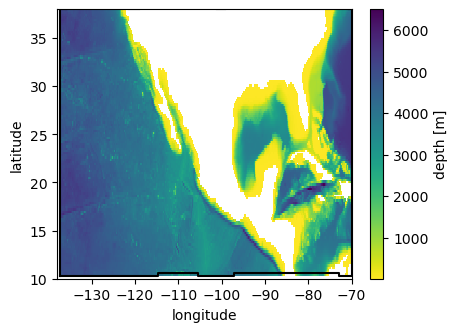

In [14]:
import numpy as np
import regionate
import matplotlib.pyplot as plt

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "MANSO"
#lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
#lons = np.arange([-138, 0, 3.4])
lons = np.array([-138.,-120.,-100., -70., -70., -100., -120., -138.])
#lats = np.arange(8, 49, 1)
lats = np.array([10., 10., 10., 10., 38., 38., 38., 38.])
#lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
manso_region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(manso_region.lons), regionate.loop(manso_region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");
plt.xlim(np.min(lons), np.max(lons))
plt.ylim(np.min(lats), np.max(lats))

#plt.xlim(-200,5)
#plt.ylim(-10,80)

In [15]:
import warnings

lam = "heat"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        manso_region.mask
    )
    wmb.mass_budget(lam, greater_than=True, default_bins=True)
    wmt = wmb.wmt


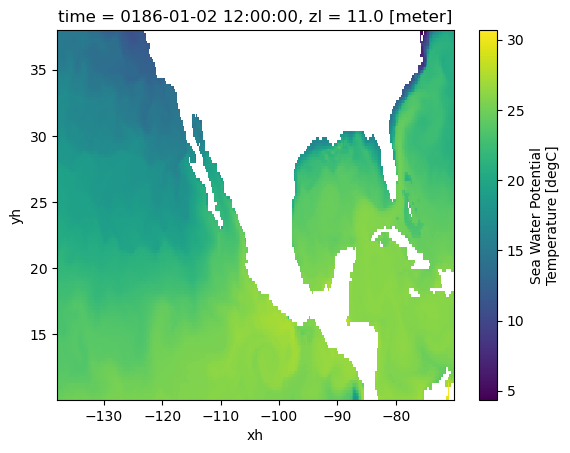

In [16]:
wm.grid._ds['thetao'].isel(time=0).isel(zl=5).sel(yh=slice(9,38)).sel(xh=slice(-138,-70)).plot()

In [17]:
temp = wm.grid._ds['thetao'].isel(time=7).sel(yh=28, method="nearest").sel(xh=slice(-138,-70)).compute()
z_section = wm.grid._ds['z'].isel(time=7).sel(yh=28, method="nearest").sel(xh=slice(-138,-70)).compute()

In [18]:
dates_evo = {
    'day1': (186, 6, 30), #No MHW
    'day2': (186, 7, 15), #No MHW
    'day3': (186, 7, 26), #MHW
    'day4': (186, 8, 3), #MHW
    'day5': (186, 8, 10), #MHW
    'day6': (186, 8, 21), #MHW
    'day7': (186, 8, 28), #MHW
    'day8': (186, 9, 5), #MHW
    'day9': (186, 9, 15), #MHW
    'day10': (186, 9, 30), #No MHW
    'day11': (186, 10, 5), #No MHW
    'day12': (186, 10, 15), #No MHW
}

In [19]:
def convert_to_date_string(date_tuple):
    year, month, day = date_tuple
    return f"{year:04d}-{month:02d}-{day:02d}"

In [134]:
day = 'day3'

In [135]:
day_save = dates_evo[f'{day}']
date_save = convert_to_date_string(day_save)
date_save

'0186-07-26'

In [136]:
import cftime
import cmocean

In [137]:
date_sel = cftime.DatetimeNoLeap(dates_evo[f'{day}'][0], dates_evo[f'{day}'][1], dates_evo[f'{day}'][2])

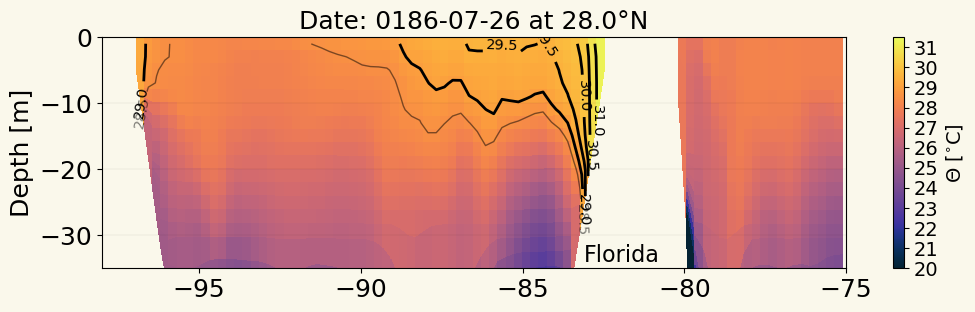

In [138]:
yh=28
temp = wm.grid._ds['thetao'].sel(time=date_sel, method="nearest").sel(yh=yh, method="nearest").sel(xh=slice(-98, -75)).compute()
z_section = wm.grid._ds['z'].sel(time=date_sel, method="nearest").sel(yh=yh, method="nearest").sel(xh=slice(-98, -75)).compute()

#y = z_section.time.dt.year.values
#m = z_section.time.dt.month.values
#d = z_section.time.dt.day.values
back_color='#faf8eb' #'#faf8eb' yeallowish for presentation

fig, ax = plt.subplots(figsize=(12, 3), facecolor=back_color)  # Updated figsize
ax.set_facecolor(back_color)

fontsize=18
min=20
max=31.5
plt.pcolor(
    z_section.xh * xr.ones_like(z_section.zl),
    z_section,
    temp.transpose(),
    vmin=min,
    vmax=max,
    cmap=cmocean.cm.thermal
)

colorbar = plt.colorbar()
colorbar.set_label((r"$\Theta$ [$^{\circ}$C]"), fontsize=14)  # Add title to the colorbarr"${\theta}$ [deg/C]"
colorbar.set_ticks(np.arange(min, max, 1))  # Set tick marks on the colorbarSea Water Potential Temperature
colorbar.set_ticks(np.arange(min, max, 1), minor=True)
colorbar.ax.tick_params(labelsize=14)

# Adding contour lines for temperature
contour29 = plt.contour(
    z_section.xh * xr.ones_like(z_section.zl),
    z_section,
    temp.transpose(),
    levels=np.arange(29, 31.5, 0.5),
    colors='black',
    linewidths=2,
    linestyles='solid'
)

contour28 = plt.contour(
    z_section.xh * xr.ones_like(z_section.zl),
    z_section,
    temp.transpose(),
    levels=np.arange(28.5, 29, 0.5),
    colors='black',
    alpha=0.5,
    linewidths=1,
    linestyles='solid'
)

h=-35
#plt.xlim(-98, -75)
ax.set_ylim(h, 0)
ax.set_xlim(-98, -75)
ax.clabel(contour29, inline=True, fontsize=10.5)
ax.clabel(contour28, inline=True, fontsize=10.5)
#ax.set_xlabel('Longitude', fontsize=fontsize)  # Add label for the x-axis
ax.set_ylabel('Depth [m]', fontsize=fontsize)   # Add label for the y-axis

ax.tick_params(axis='both', labelsize=fontsize)

plt.annotate(
    'Florida', 
    xy=(-80, -30), #(-80, -30)
    xytext=(-83.1, -34), #(-83.1, -34) (-82.5, -34)
    fontsize=16,
    color='k',
    #weight='bold',
    #rotation=180
    #arrowprops=dict(facecolor='k', shrink=0.05)
)


plt.title(f'Date: {date_save} at {np.round(z_section.yh.values)}°N', fontsize=fontsize)
plt.grid(axis="y", alpha=0.8,color="k", linestyle="-", linewidth=0.05)
#plt.savefig(f'/pub/mariant3/WarmWaterMasses/figures/zsection/zsection-{yh}N-{date_save}{h}m-talk-background.png', bbox_inches='tight')

#plt.tight_layout()
plt.show()